## Debye Theory
$$A(r) = \frac{2\pi i}{\lambda}\sum_{n=1}^{N}s_n \int_{\theta_{n-1}}^{\theta_n}\sqrt{\cos \theta}J_0(kr\sin\theta) \sin \theta d\theta,$$
$$= i \sum_{n=1}^{N} s_n A_n(r) $$
where $s_n \in \{-1,1\} $ and 
$$A_n(r)=\frac{2\pi }{\lambda}\int_{\theta_{n-1}}^{\theta_n}\sqrt{\cos \theta}J_0(kr\sin\theta) \sin \theta d\theta.$$
## Cost Function of Amplitude Approach

Consider a target amplitude function $A_{t}(r)>0$  
The cost function 
$$f(\mathbf{s}) = \int_{0}^{R} |A(r)-A_t(r)|^2 dr$$
Note that $A_t(r)$ is purely real and positive, but $A(r)$ is purely imaginary. This means that 
the cost function can never be zero. However, the phase of $A(r)$ from $i$ is simply a choice of reference. One can add a $\pi/2$ phase to $A(r)$ to cancel the $i$. From now on, we use the definition of 
$$A(r) = \frac{2\pi }{\lambda}\sum_{n=1}^{N}s_n \int_{\theta_{n-1}}^{\theta_n}\sqrt{\cos \theta}J_0(kr\sin\theta) \sin \theta d\theta,$$
$$=  \sum_{n=1}^{N} s_n A_n(r) $$

The cost function becomes (note that in our definition, both $A_n(r)$ and $A_t(r)$ are real)
$$\sum_{m,n} \left(\int_{0}^{R}A_n(r)A_m(r)dr \right) s_m s_n - 2 \sum_{n} \left(\int_0^{R}A_n(r)A_t(r)dr\right)s_n + \int_0^{R} A_t^2(r) dr$$
$$=\sum_{ij} Q_{ij}s_is_j + \sum_{i} h_i s_i +\mathrm{constant}$$
The Hamiltonian is then 

$$\mathcal H = \sum_{ij} J_{ij}s_is_j + \sum_{i} h_i s_i$$
with 
$$J_{ij} = \int_{0}^{R} A_i(r) A_j(r) dr $$
$$h_{ij} = -2\int_{0}^{R} A_i(r) A_t(r) dr $$

Reference: Laser Photonics Rev. 8, No. 1, 152–157 (2014)

## Implement
We consider a numerical aperture $NA=0.95$, that is $\sin(\theta_{max})=0.95$. We split $theta$ evenly with $\Delta \theta = \theta_{max}/64$, with 64 qubits. The computation of each $Q_{ij}$ is expensive for the double integrals over $\theta$ and $r$. Thus, we approximate the integral over $r$ by a summation,
$$\int_0^{r}(...)dr \simeq \sum_{r_i} (...) \Delta r$$
First, we choose a uniform $r_i$ with
``` python
Nr = 100 
R = 8 * lamb
ri = np.linspace(0, R, Nr)
```


In [252]:
import numpy as np
from scipy.integrate import quad
from scipy.special import j0
from scipy import integrate
import time

In [265]:
lamb = 1
k = 2 * np.pi / lamb
r_max = 8 * lamb 
theta_max = np.arcsin(0.95)
theta_min = 0 * np.pi/2
Nr = 1000
Nq = 64 # 64 qubit
thetav = np.linspace(theta_min,theta_max, Nq + 1) # 64 rings
rv = np.linspace(0,r_max,Nr) ## uniform

An = np.zeros([Nq,Nr]) ## A1 = An[0], A2 = An[1],

# Define the function you want to integrate
def integrand(theta,r):
    tmp = np.sqrt(np.cos(theta)) * j0( k * r *np.sin(theta)) * np.sin(theta)
    return tmp

for iq in range(Nq):
    for ir in range(Nr):
        r_cur = rv[ir]
        theta_s = thetav[iq] 
        theta_l = thetav[iq+1]
        An[iq,ir], error = quad(lambda theta: integrand(theta,r_cur), theta_s,theta_l)

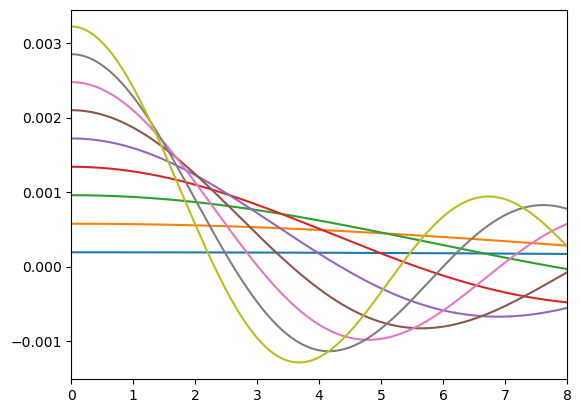

In [266]:
## plot of the images of the first 10 rings
import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.plot(rv, np.transpose(An[0:9]))
plt.xlim([0,r_max])
#plt.ylim([0,1])
plt.show()

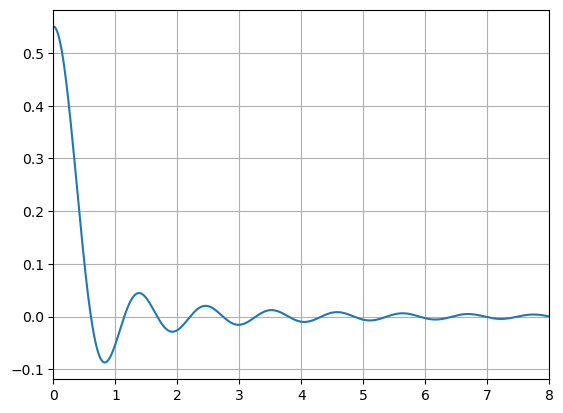

In [267]:
## plot of the a focusing case
# All si = 1 
Atot = np.sum(An,axis = 0)

plt.figure(dpi=100)
plt.plot(rv, Atot)
plt.xlim([0,r_max])
plt.grid()
plt.show()

In [268]:
def amp_design(s): # s=[1,1,-1,1,...] configuration
    A_design = np.zeros(Nr)
    for i in range(Nq):
        A_design = A_design + s[i] * An[i]
    return A_design
    

|J_min/J_max| = 0.004449031484727151
|h_min/h_max| = 0.017105322785383723
|J_min/h_max| = 0.0006059745758810509


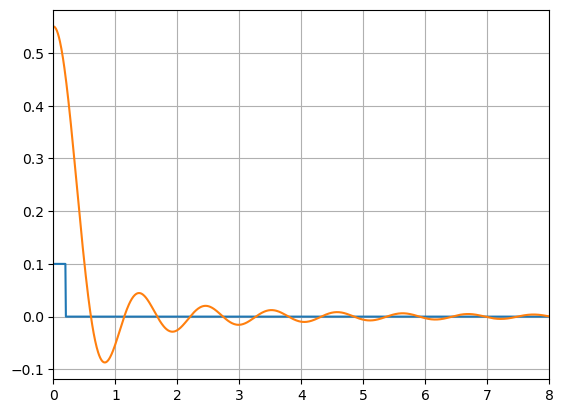

In [395]:
## compute Q_ij, h_i
J = np.zeros([Nq,Nq])
h = np.zeros(Nq)
At = np.zeros(Nr)
At[0:int(0.2/r_max * Nr)] = 0.1
s_test =  np.random.choice([1, -1], size=64)
s_test = np.ones(64)
s_test[0:63] = -1
# At = 0.22 * j0( 2 * k * rv )
#At = amp_design(s_test)

#At = Atot
weight = np.ones(Nr)
#weight[100:Nr] = 1
#weight = weight *np.exp(-(rv/0.2)**2)
for i1 in range(Nq):
    h[i1] = - 2 * np.sum(An[i1] * At * weight) 
    for i2 in range(Nq): 
        J[i1,i2] = np.sum(An[i1] * An[i2] * weight)
print(f'|J_min/J_max| = {np.min(np.abs(J))/np.max(np.abs(J))}')
print(f'|h_min/h_max| = {np.min(np.abs(h))/np.max(np.abs(h))}')
print(f'|J_min/h_max| = {np.min(np.abs(J))/np.max(np.abs(h))}')
## plot of At 

plt.figure(dpi=100)
plt.plot(rv, At)
plt.plot(rv, Atot)
plt.xlim([0,r_max])
plt.grid()
plt.show()

In [391]:
import numpy as np
from neal import Neal

# Assuming you have your h vector and J matrix defined
# For a 64-bit problem, h should have 64 elements
# and J should be a 64x64 matrix (or a dictionary of interactions)

# Example: Replace with your actual h and J
# h = {i: np.random.randn() for i in range(64)}
# J = {(i, j): np.random.randn() for i in range(64) for j in range(i + 1, 64)}
# OR for a matrix:
# J_matrix = np.random.randn(64, 64)
# J = {(i, j): J_matrix[i, j] for i in range(64) for j in range(i + 1, 64)}

# Let's create a simple example h and J for demonstration with 64 variables
num_variables = Nq
h_dic = {i: h[i] for i in range(num_variables)} # Linear bias
J_dic = {(i, j): J[i,j] for i in range(num_variables) for j in range(i + 1, num_variables)} # Random interactions

# Create a Neal sampler instance
sampler = Neal()

# Run simulated annealing
# num_reads specifies how many independent samples to collect
num_reads = 1000

print(f"Running simulated annealing for {num_variables} variables...")
sampleset = sampler.sample_ising(h_dic, J_dic, num_reads=num_reads)

print("Simulated annealing complete.")

# The result is a SampleSet object
# You can access the samples, energies, and occurrences
print(f"Number of samples returned: {len(sampleset)}")
print(f"Lowest energy found: {sampleset.first.energy}")
print(f"Sample with the lowest energy: {sampleset.first.sample}")

# You can iterate through the samples
# for sample, energy, occurrences in sampleset.data():
#     print(f"Sample: {sample}, Energy: {energy}, Occurrences: {occurrences}")

# Or convert to a pandas DataFrame
# df = sampleset.to_pandas_dataframe()
# print(df.head())

Running simulated annealing for 64 variables...
Simulated annealing complete.
Number of samples returned: 1000
Lowest energy found: -0.4954281385227456
Sample with the lowest energy: {0: 1, 1: -1, 2: 1, 3: 1, 4: -1, 5: -1, 6: 1, 7: 1, 8: 1, 9: -1, 10: -1, 11: 1, 12: 1, 13: 1, 14: -1, 15: -1, 16: 1, 17: 1, 18: 1, 19: -1, 20: -1, 21: 1, 22: 1, 23: 1, 24: -1, 25: -1, 26: 1, 27: 1, 28: 1, 29: -1, 30: 1, 31: -1, 32: 1, 33: -1, 34: 1, 35: 1, 36: 1, 37: -1, 38: 1, 39: -1, 40: -1, 41: 1, 42: 1, 43: 1, 44: 1, 45: -1, 46: -1, 47: -1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: -1, 54: 1, 55: -1, 56: 1, 57: -1, 58: -1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1}


In [392]:
s_best = np.zeros(Nq)
for i in range(Nq):
    s_best[i] = sampleset.first.sample[i]
print(s_best)

[ 1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.
  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.
  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.]


In [393]:
A_best = np.zeros(Nr)
for i in range(Nq):
    A_best = A_best + s_best[i] * An[i]

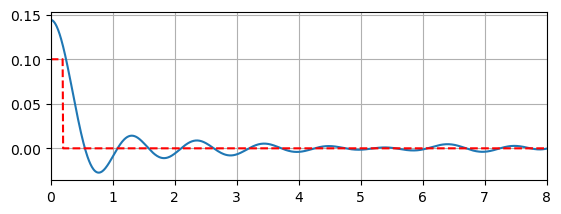

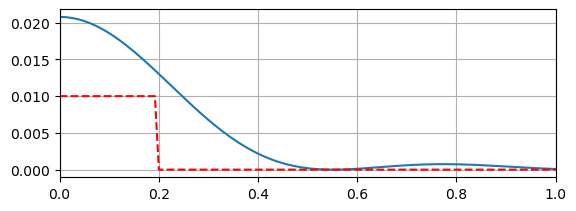

In [394]:
plt.subplot(2,1,1)
plt.plot(rv, A_best)
plt.plot(rv, At,'r--')
plt.xlim(0,r_max)
plt.grid()
plt.show()
plt.subplot(2,1,2)
plt.plot(rv, A_best**2)
plt.plot(rv, At**2,'r--')
plt.xlim(0,1)
plt.grid()
plt.show()